In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior, accuracy
from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# Logistic regression

In [3]:


key = random.PRNGKey(42)
dim = 10
# Ndata = 100_000
Ndata = 1_000_000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)
data = (X_train, y_train)


# batch_size = int(0.01*X.shape[0])
gridsearch_bs = int(0.1*X_train.shape[0])
centering_value = theta_true
key = random.PRNGKey(0)

dt_baseline = 1/Ndata

generating data, with N=1,000,000 and dim=10
(800000, 10) (200000, 10)


In [4]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

NUTS_stds = np.genfromtxt("outputs/LR_uncertainty_tests/NUTS_stds.txt")

def get_relative_error_LR(estimate, ground_truth=NUTS_stds):
    "compare to NUTS samples"
    return np.linalg.norm(estimate - ground_truth)/np.linalg.norm(ground_truth)

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)
batch_grad_log_post = jit(vmap(lambda x: grad_log_post(x, *data)))

def get_fb_grads_batches(samples, calc_batch_size):
    """
    Calculate the fullbatch gradients, but in batches
    """
    samples = jnp.array(samples)
    list_grads = []
    len_sgld = samples.shape[0]
    num_steps = int(np.ceil(len_sgld/calc_batch_size))
    for i in range(num_steps):
        new_grads = batch_grad_log_post(samples[i*calc_batch_size:(i+1)*calc_batch_size])
        wait_until_computed(new_grads)
        list_grads.append(new_grads)
    fb_grads = jnp.concatenate(list_grads, axis=0)
    return fb_grads

def get_ksd_LR(samples, thin_step):
#     grad_log_post = build_grad_log_post(loglikelihood, logprior, data)
#     batch_grad_log_post = jit(vmap(lambda x: grad_log_post(x, *data)))
    
    num_samples = len(samples)
    samples_array = jnp.array(samples[::thin_step])
#     fb_grads = batch_grad_log_post(samples_array)
    fb_grads = get_fb_grads_batches(samples_array, 500)
    return imq_KSD(samples_array, fb_grads)

def assess_LR_samples(samples, thin_step):
    print(f"assessing the samples. Num samples: {len(samples)}")
    ksd_est = get_ksd_LR(samples, thin_step)
    std_error = get_relative_error_LR(np.std(samples, axis=0))
    samples_array = jnp.array(samples[::thin_step])
    pred_acc = accuracy(samples_array, X_test, y_test)
    return ksd_est, pred_acc, std_error, len(samples)
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=theta_true):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_LR_samples(samples, thin)



### build partial kernels

In [4]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

# time_budget = 5
# thin = 5

time_budget = 10
thin = 10


# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20


Order: mamba-ksd, mamba-fssd, gridsearch, baseline

sgld:

- 66.769, 0.93894, 0.28368, 22255
- 58.244003, 0.938945, 0.6853, 21851
- 105.8, 0.93898, 0.12, 4005
- 100.496, 0.939, 0.121, 3484)

sgld-cv:

- 12.488, 0.93896, 0.0515, 55580
- 22.73, 0.9389, 0.0592, 18792
- 38.0675, 0.93895495, 0.124, 3232
- 102.98, 0.93896496, 0.2747, 2809

sghmc:

- 85.02, 0.938945, 1.0777, 28268
- 56.0, 0.93895, 0.825, 5145
- 173.69, 0.9389, 0.345, 435
- 53972.938, 0.926785, 30.30, 428 

sghmc-cv:

- 18.46, 0.93895495, 0.0840, 24001
- 43.3, 0.93896, 0.263, 4194
- 131.44, 0.938935, 0.3128, 355
- 51565.29, 0.92731, 30.8398, 346

sgnht:

- 69.19249, 0.93894, 0.5575, 21955
- 67.58486, 0.938945, 1.025, 19845
- 72.52107, 0.93896997, 0.150161, 4055
- 50.550007, 0.93895495, 0.7139, 4056

sgnht-cv:

- 3.2341034, 0.938935, 0.0082234, 19323
- 10.972629, 0.93895495, 0.0201, 3105
- 12.268697, 0.938945, 0.10454, 3329
- 9.015524, 0.93895, 0.20406, 3329


In [5]:
    
# def _run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=theta_true):
#     timed_sampler_factory = timed_sampler(build_kernel)
#     my_timed_sampler = timed_sampler_factory(**dict_params)
#     samples, _ = my_timed_sampler(key, time_budget, params_IC)
#     return samples



In [6]:
# sh_params = {'batch_size': 800_000, 'dt': 1e-06}

# mysams = _run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params)

In [31]:
# mamba-ksd, fb, thin, small bs grid (100, 10, 1, 0.1)
sh_params = {'batch_size': 8000, 'dt': 1e-06}#{'batch_size': 8000, 'dt': 3.1622776e-06}

print(run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params))

assessing the samples. Num samples: 22255
(DeviceArray(66.768684, dtype=float32), DeviceArray(0.93894, dtype=float32), 0.2836863383703494, 22255)


In [5]:
# mamba-FSSD, fb, thin, small bs grid (100, 10, 1, 0.1), R = 1
sh_params = {'batch_size': 8000, 'dt': 3.1622776e-06}

print(run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params))

assessing the samples. Num samples: 21823


KeyboardInterrupt: 

In [32]:
sh_params = {'batch_size': 8000, 'dt': 3.1622776e-06}# {'batch_size': 800000, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 1e-6}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgld, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgld, thin, baseline_params))

assessing the samples. Num samples: 21730
(DeviceArray(57.20073, dtype=float32), DeviceArray(0.938945, dtype=float32), 0.6856817786122548, 21730)
assessing the samples. Num samples: 4005
(Buffer(105.82804, dtype=float32), DeviceArray(0.93898, dtype=float32), 0.1225381214751977, 4005)
assessing the samples. Num samples: 3484
(DeviceArray(100.495804, dtype=float32), DeviceArray(0.938975, dtype=float32), 0.1206324179036239, 3484)


### sgld-cv

In [33]:
# mamba-ksd, fb, thin, small bs grid (100, 10, 1, 0.1)
sh_params = {'batch_size': 800, 'dt': 1e-05}

print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params))

assessing the samples. Num samples: 55580
(DeviceArray(12.487664, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.0514501310199361, 55580)


In [ ]:
# mamba-FSSD, fb, thin, small bs grid (100, 10, 1, 0.1), R=1
sh_params = {'batch_size': 8000, 'dt': 1e-05}

print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params))

In [34]:
sh_params = {'batch_size': 800, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, baseline_params))

assessing the samples. Num samples: 54711
(DeviceArray(16.87158, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.03415539145604198, 54711)
assessing the samples. Num samples: 3232
(DeviceArray(38.067535, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.12422500924511648, 3232)
assessing the samples. Num samples: 2809
(DeviceArray(102.981514, dtype=float32), DeviceArray(0.93896496, dtype=float32), 0.27465690790886366, 2809)


### sghmc

In [35]:
# mamba-ksd, fb, thin, small bs grid (100, 10, 1, 0.1)
sh_params = {'batch_size': 800, 'L': 10, 'dt': 1e-07}# {'batch_size': 8000, 'L': 5, 'dt': 1e-06}

print(run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params))

assessing the samples. Num samples: 28268
(DeviceArray(85.02006, dtype=float32), DeviceArray(0.938945, dtype=float32), 1.0776858187042484, 28268)


In [ ]:
# mamba-FSSD, fb, thin, small bs grid (100, 10, 1, 0.1), R=1
sh_params = {'batch_size': 8000, 'L': 5, 'dt': 1e-06}

print(run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params))

In [36]:
sh_params = {'batch_size': 800, 'L': 5, 'dt': 3.1622776e-08}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-07}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmc, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sghmc, thin, baseline_params))

assessing the samples. Num samples: 41460
(DeviceArray(68.99483, dtype=float32), DeviceArray(0.93894, dtype=float32), 0.31553132130700684, 41460)
assessing the samples. Num samples: 435
(DeviceArray(173.69005, dtype=float32), DeviceArray(0.93891495, dtype=float32), 0.34501051623841866, 435)
assessing the samples. Num samples: 428
(DeviceArray(53972.938, dtype=float32), DeviceArray(0.926785, dtype=float32), 30.302689241159527, 428)


### sghmc-cv

In [37]:
# mamba-ksd, fb, thin, small bs grid (100, 10, 1, 0.1)
sh_params = {'batch_size': 800, 'L': 10, 'dt': 3.1622776e-07} #{'batch_size': 8000, 'L': 5, 'dt': 1e-06}

print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params))

assessing the samples. Num samples: 24001
(DeviceArray(18.458473, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.08401671657003944, 24001)


In [ ]:
# mamba-FSSD, fb, thin, small bs grid (100, 10, 1, 0.1), R=1
sh_params = {'batch_size': 8000, 'L': 5, 'dt': 1e-06}

print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params))

In [38]:
sh_params = {'batch_size': 80, 'L': 10, 'dt': 1e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 3.1622776e-07}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, baseline_params))

assessing the samples. Num samples: 55766
(DeviceArray(15.014843, dtype=float32), DeviceArray(0.93895996, dtype=float32), 0.08456528048248936, 55766)
assessing the samples. Num samples: 355
(DeviceArray(131.43513, dtype=float32), DeviceArray(0.938935, dtype=float32), 0.3128114032696781, 355)
assessing the samples. Num samples: 346
(DeviceArray(51565.29, dtype=float32), DeviceArray(0.92731, dtype=float32), 30.839844496561955, 346)


### sgnht

In [39]:
# mamba-ksd, fb, thin, small bs grid (100, 10, 1, 0.1)
sh_params = {'batch_size': 8000, 'dt': 3.1622776e-08} 

print(run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params))

assessing the samples. Num samples: 21955
(DeviceArray(69.19249, dtype=float32), DeviceArray(0.93894, dtype=float32), 0.5574707347655071, 21955)


In [ ]:
# mamba-FSSD, fb, thin, small bs grid (100, 10, 1, 0.1), R=1
sh_params = {'batch_size': 8000, 'dt': 1e-06}

print(run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params))

In [40]:
sh_params = {'batch_size': 800000, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-08}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnht, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgnht, thin, baseline_params))

assessing the samples. Num samples: 1211
(DeviceArray(11.67352, dtype=float32), DeviceArray(0.93895, dtype=float32), 0.09304767293649484, 1211)
assessing the samples. Num samples: 4055
(DeviceArray(72.52107, dtype=float32), DeviceArray(0.93896997, dtype=float32), 0.15016108513448748, 4055)
assessing the samples. Num samples: 4056
(Buffer(50.550007, dtype=float32), DeviceArray(0.93895495, dtype=float32), 0.7139230636939985, 4056)


### sgnht-cv

In [41]:
# mamba-ksd, fb, thin, small bs grid (100, 10, 1, 0.1)
sh_params = {'batch_size': 8000, 'dt': 3.1622776e-06}# {'batch_size': 8000, 'dt': 3.1622776e-06}

print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params))

assessing the samples. Num samples: 19323
(DeviceArray(3.2341034, dtype=float32), DeviceArray(0.938935, dtype=float32), 0.008223429462736907, 19323)


In [ ]:
# mamba-FSSD, fb, thin, small bs grid (100, 10, 1, 0.1), R=1
sh_params = {'batch_size': 80000, 'dt': 1e-05}

print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params))

In [42]:
sh_params = {'batch_size': 8000, 'dt': 1e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params))
print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, baseline_params))

assessing the samples. Num samples: 19380
(DeviceArray(4.5169606, dtype=float32), DeviceArray(0.938945, dtype=float32), 0.019522570623525488, 19380)
assessing the samples. Num samples: 3329
(DeviceArray(12.268697, dtype=float32), DeviceArray(0.938945, dtype=float32), 0.10454218173192205, 3329)
assessing the samples. Num samples: 3329
(Buffer(9.015524, dtype=float32), DeviceArray(0.93895, dtype=float32), 0.20406189966833738, 3329)


# 2. KSD curves

In [5]:
gridsearch_bs

80000

In [7]:
X_train.shape

(800000, 10)

In [9]:
np.log10(3.1622776e-06)

-5.500000008263283

### sgld

In [7]:
# error_fn_ksd_curve = partial(get_ksd_LR, thin_step=20)
# list_time_budget = [2, 4, 6, 8, 10]

error_fn_ksd_curve = partial(get_ksd_LR, thin_step=10)
list_time_budget = [1, 2, 3, 4, 5]

In [47]:
dict_params = {'batch_size': 8000, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 2234
Budget: 2, num_samples = 4563
Budget: 3, num_samples = 6856
Budget: 4, num_samples = 9158
Budget: 5, num_samples = 11286

Iteration 1/10
Budget: 1, num_samples = 2203
Budget: 2, num_samples = 4521
Budget: 3, num_samples = 6802
Budget: 4, num_samples = 8871
Budget: 5, num_samples = 9733

Iteration 2/10
Budget: 1, num_samples = 2079
Budget: 2, num_samples = 3868
Budget: 3, num_samples = 6037
Budget: 4, num_samples = 8288
Budget: 5, num_samples = 10262

Iteration 3/10
Budget: 1, num_samples = 2139
Budget: 2, num_samples = 4239
Budget: 3, num_samples = 6331
Budget: 4, num_samples = 8588
Budget: 5, num_samples = 10442

Iteration 4/10
Budget: 1, num_samples = 2103
Budget: 2, num_samples = 4228
Budget: 3, num_samples = 6347
Budget: 4, num_samples = 8577
Budget: 5, num_samples = 9882

Iteration 5/10
Budget: 1, num_samples = 2144
Budget: 2, num_samples = 4370
Budget: 3, num_samples = 6581
Budget: 4, num_

In [8]:
dict_params = {'batch_size': 8000, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba_fssd, sd_ksd_curve_sgld_mamba_fssd = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 1, num_samples = 2184
Budget: 2, num_samples = 4196
Budget: 3, num_samples = 6421
Budget: 4, num_samples = 8274
Budget: 5, num_samples = 10067

Iteration 1/10
Budget: 1, num_samples = 2030
Budget: 2, num_samples = 4286
Budget: 3, num_samples = 6299
Budget: 4, num_samples = 8385
Budget: 5, num_samples = 10207

Iteration 2/10
Budget: 1, num_samples = 2040
Budget: 2, num_samples = 4059
Budget: 3, num_samples = 6277
Budget: 4, num_samples = 8445
Budget: 5, num_samples = 10620

Iteration 3/10
Budget: 1, num_samples = 2122
Budget: 2, num_samples = 4355
Budget: 3, num_samples = 6763
Budget: 4, num_samples = 8271
Budget: 5, num_samples = 8187

Iteration 4/10
Budget: 1, num_samples = 1709
Budget: 2, num_samples = 2873
Budget: 3, num_samples = 5629
Budget: 4, num_samples = 8260
Budget: 5, num_samples = 10547

Iteration 5/10
Budget: 1, num_samples = 2180
Budget: 2, num_samples = 4176
Budget: 3, num_samples = 6206
Budget

In [48]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-6}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 326
Budget: 2, num_samples = 758
Budget: 3, num_samples = 1157
Budget: 4, num_samples = 1553
Budget: 5, num_samples = 1925

Iteration 1/10
Budget: 1, num_samples = 385
Budget: 2, num_samples = 766
Budget: 3, num_samples = 1153
Budget: 4, num_samples = 1323
Budget: 5, num_samples = 1910

Iteration 2/10
Budget: 1, num_samples = 374
Budget: 2, num_samples = 660
Budget: 3, num_samples = 1178
Budget: 4, num_samples = 1575
Budget: 5, num_samples = 2044

Iteration 3/10
Budget: 1, num_samples = 405
Budget: 2, num_samples = 811
Budget: 3, num_samples = 1216
Budget: 4, num_samples = 1321
Budget: 5, num_samples = 1652

Iteration 4/10
Budget: 1, num_samples = 393
Budget: 2, num_samples = 770
Budget: 3, num_samples = 952
Budget: 4, num_samples = 1458
Budget: 5, num_samples = 1981

Iteration 5/10
Budget: 1, num_samples = 332
Budget: 2, num_samples = 664
Budget: 3, num_samples = 1144
Budget: 4, num_samples = 1565


In [49]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 326
Budget: 2, num_samples = 652
Budget: 3, num_samples = 990
Budget: 4, num_samples = 1312
Budget: 5, num_samples = 1634

Iteration 1/10
Budget: 1, num_samples = 389
Budget: 2, num_samples = 651
Budget: 3, num_samples = 928
Budget: 4, num_samples = 1287
Budget: 5, num_samples = 1889

Iteration 2/10
Budget: 1, num_samples = 407
Budget: 2, num_samples = 659
Budget: 3, num_samples = 989
Budget: 4, num_samples = 1312
Budget: 5, num_samples = 1654

Iteration 3/10
Budget: 1, num_samples = 331
Budget: 2, num_samples = 662
Budget: 3, num_samples = 992
Budget: 4, num_samples = 1617
Budget: 5, num_samples = 2018

Iteration 4/10
Budget: 1, num_samples = 405
Budget: 2, num_samples = 660
Budget: 3, num_samples = 985
Budget: 4, num_samples = 1316
Budget: 5, num_samples = 1646

Iteration 5/10
Budget: 1, num_samples = 330
Budget: 2, num_samples = 658
Budget: 3, num_samples = 989
Budget: 4, num_samples = 1313
Budge

In [10]:
dt_baseline

1e-06

### sgld-cv

In [50]:
dict_params = {'batch_size': 800, 'dt': 1e-05}#{'batch_size': 800, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'dt': 1e-05}

Iteration 0/10
Budget: 1, num_samples = 5584
Budget: 2, num_samples = 9889
Budget: 3, num_samples = 15300
Budget: 4, num_samples = 21302
Budget: 5, num_samples = 25141

Iteration 1/10
Budget: 1, num_samples = 5597
Budget: 2, num_samples = 11145
Budget: 3, num_samples = 14901
Budget: 4, num_samples = 21969
Budget: 5, num_samples = 26771

Iteration 2/10
Budget: 1, num_samples = 5536
Budget: 2, num_samples = 10260
Budget: 3, num_samples = 15249
Budget: 4, num_samples = 21601
Budget: 5, num_samples = 26239

Iteration 3/10
Budget: 1, num_samples = 5412
Budget: 2, num_samples = 11148
Budget: 3, num_samples = 15844
Budget: 4, num_samples = 21747
Budget: 5, num_samples = 26481

Iteration 4/10
Budget: 1, num_samples = 5504
Budget: 2, num_samples = 11988
Budget: 3, num_samples = 17116
Budget: 4, num_samples = 22611
Budget: 5, num_samples = 15569

Iteration 5/10
Budget: 1, num_samples = 4357
Budget: 2, num_samples = 8850
Budget: 3, num_samples = 13146

In [9]:
dict_params = {'batch_size': 8000, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba_fssd, sd_ksd_curve_sgldCV_mamba_fssd = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1e-05}

Iteration 0/10
Budget: 1, num_samples = 1860
Budget: 2, num_samples = 3824
Budget: 3, num_samples = 5558
Budget: 4, num_samples = 7372
Budget: 5, num_samples = 8616

Iteration 1/10
Budget: 1, num_samples = 1839
Budget: 2, num_samples = 3396
Budget: 3, num_samples = 5307
Budget: 4, num_samples = 7274
Budget: 5, num_samples = 9311

Iteration 2/10
Budget: 1, num_samples = 1942
Budget: 2, num_samples = 3864
Budget: 3, num_samples = 5681
Budget: 4, num_samples = 7737
Budget: 5, num_samples = 9609

Iteration 3/10
Budget: 1, num_samples = 1779
Budget: 2, num_samples = 3778
Budget: 3, num_samples = 5635
Budget: 4, num_samples = 7769
Budget: 5, num_samples = 9188

Iteration 4/10
Budget: 1, num_samples = 1941
Budget: 2, num_samples = 3748
Budget: 3, num_samples = 5788
Budget: 4, num_samples = 7820
Budget: 5, num_samples = 9515

Iteration 5/10
Budget: 1, num_samples = 1938
Budget: 2, num_samples = 3875
Budget: 3, num_samples = 5699
Budget: 4, num_sam

In [51]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-05}

Iteration 0/10
Budget: 1, num_samples = 268
Budget: 2, num_samples = 538
Budget: 3, num_samples = 692
Budget: 4, num_samples = 1024
Budget: 5, num_samples = 1345

Iteration 1/10
Budget: 1, num_samples = 259
Budget: 2, num_samples = 521
Budget: 3, num_samples = 693
Budget: 4, num_samples = 1040
Budget: 5, num_samples = 1372

Iteration 2/10
Budget: 1, num_samples = 279
Budget: 2, num_samples = 541
Budget: 3, num_samples = 809
Budget: 4, num_samples = 1095
Budget: 5, num_samples = 1360

Iteration 3/10
Budget: 1, num_samples = 274
Budget: 2, num_samples = 530
Budget: 3, num_samples = 828
Budget: 4, num_samples = 1081
Budget: 5, num_samples = 1319

Iteration 4/10
Budget: 1, num_samples = 259
Budget: 2, num_samples = 544
Budget: 3, num_samples = 816
Budget: 4, num_samples = 1099
Budget: 5, num_samples = 1334

Iteration 5/10
Budget: 1, num_samples = 279
Budget: 2, num_samples = 562
Budget: 3, num_samples = 822
Budget: 4, num_samples = 1093
Budge

In [52]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 264
Budget: 2, num_samples = 534
Budget: 3, num_samples = 818
Budget: 4, num_samples = 1080
Budget: 5, num_samples = 1324

Iteration 1/10
Budget: 1, num_samples = 272
Budget: 2, num_samples = 533
Budget: 3, num_samples = 813
Budget: 4, num_samples = 1088
Budget: 5, num_samples = 1357

Iteration 2/10
Budget: 1, num_samples = 269
Budget: 2, num_samples = 544
Budget: 3, num_samples = 814
Budget: 4, num_samples = 1095
Budget: 5, num_samples = 1331

Iteration 3/10
Budget: 1, num_samples = 217
Budget: 2, num_samples = 502
Budget: 3, num_samples = 781
Budget: 4, num_samples = 1215
Budget: 5, num_samples = 1404

Iteration 4/10
Budget: 1, num_samples = 276
Budget: 2, num_samples = 514
Budget: 3, num_samples = 763
Budget: 4, num_samples = 948
Budget: 5, num_samples = 1203

Iteration 5/10
Budget: 1, num_samples = 249
Budget: 2, num_samples = 542
Budget: 3, num_samples = 809
Budget: 4, num_samples = 1061
Budget

### sghmc

In [53]:
dict_params = {'batch_size': 800, 'L': 10, 'dt': 1e-07}# {'batch_size': 800, 'L': 5, 'dt': 3.1622776e-08}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'L': 10, 'dt': 1e-07}

Iteration 0/10
Budget: 1, num_samples = 2653
Budget: 2, num_samples = 5377
Budget: 3, num_samples = 7958
Budget: 4, num_samples = 9254
Budget: 5, num_samples = 12794

Iteration 1/10
Budget: 1, num_samples = 2792
Budget: 2, num_samples = 5634
Budget: 3, num_samples = 8416
Budget: 4, num_samples = 11268
Budget: 5, num_samples = 14111

Iteration 2/10
Budget: 1, num_samples = 2793
Budget: 2, num_samples = 5639
Budget: 3, num_samples = 8257
Budget: 4, num_samples = 11176
Budget: 5, num_samples = 14067

Iteration 3/10
Budget: 1, num_samples = 2794
Budget: 2, num_samples = 5536
Budget: 3, num_samples = 8400
Budget: 4, num_samples = 11282
Budget: 5, num_samples = 14096

Iteration 4/10
Budget: 1, num_samples = 2797
Budget: 2, num_samples = 5611
Budget: 3, num_samples = 8400
Budget: 4, num_samples = 11277
Budget: 5, num_samples = 14115

Iteration 5/10
Budget: 1, num_samples = 2784
Budget: 2, num_samples = 5610
Budget: 3, num_samples = 8429
B

In [10]:
dict_params = {'batch_size': 8000, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba_fssd, sd_ksd_curve_sghmc_mamba_fssd = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 5, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 561
Budget: 2, num_samples = 1120
Budget: 3, num_samples = 1612
Budget: 4, num_samples = 2199
Budget: 5, num_samples = 2702

Iteration 1/10
Budget: 1, num_samples = 553
Budget: 2, num_samples = 1104
Budget: 3, num_samples = 1628
Budget: 4, num_samples = 2180
Budget: 5, num_samples = 2718

Iteration 2/10
Budget: 1, num_samples = 543
Budget: 2, num_samples = 1107
Budget: 3, num_samples = 1577
Budget: 4, num_samples = 2184
Budget: 5, num_samples = 2736

Iteration 3/10
Budget: 1, num_samples = 540
Budget: 2, num_samples = 1135
Budget: 3, num_samples = 1600
Budget: 4, num_samples = 2203
Budget: 5, num_samples = 2748

Iteration 4/10
Budget: 1, num_samples = 552
Budget: 2, num_samples = 1100
Budget: 3, num_samples = 1505
Budget: 4, num_samples = 2085
Budget: 5, num_samples = 2616

Iteration 5/10
Budget: 1, num_samples = 549
Budget: 2, num_samples = 1095
Budget: 3, num_samples = 1476
Budget: 4, num_s

In [54]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 1e-07}

Iteration 0/10
Budget: 1, num_samples = 43
Budget: 2, num_samples = 87
Budget: 3, num_samples = 126
Budget: 4, num_samples = 171
Budget: 5, num_samples = 217

Iteration 1/10
Budget: 1, num_samples = 41
Budget: 2, num_samples = 80
Budget: 3, num_samples = 126
Budget: 4, num_samples = 164
Budget: 5, num_samples = 184

Iteration 2/10
Budget: 1, num_samples = 39
Budget: 2, num_samples = 80
Budget: 3, num_samples = 118
Budget: 4, num_samples = 168
Budget: 5, num_samples = 214

Iteration 3/10
Budget: 1, num_samples = 44
Budget: 2, num_samples = 82
Budget: 3, num_samples = 126
Budget: 4, num_samples = 172
Budget: 5, num_samples = 208

Iteration 4/10
Budget: 1, num_samples = 45
Budget: 2, num_samples = 84
Budget: 3, num_samples = 129
Budget: 4, num_samples = 172
Budget: 5, num_samples = 213

Iteration 5/10
Budget: 1, num_samples = 44
Budget: 2, num_samples = 87
Budget: 3, num_samples = 129
Budget: 4, num_samples = 171
Budget: 5, num_samp

In [55]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 42
Budget: 2, num_samples = 77
Budget: 3, num_samples = 115
Budget: 4, num_samples = 165
Budget: 5, num_samples = 193

Iteration 1/10
Budget: 1, num_samples = 42
Budget: 2, num_samples = 76
Budget: 3, num_samples = 118
Budget: 4, num_samples = 172
Budget: 5, num_samples = 215

Iteration 2/10
Budget: 1, num_samples = 42
Budget: 2, num_samples = 83
Budget: 3, num_samples = 122
Budget: 4, num_samples = 97
Budget: 5, num_samples = 182

Iteration 3/10
Budget: 1, num_samples = 42
Budget: 2, num_samples = 78
Budget: 3, num_samples = 117
Budget: 4, num_samples = 158
Budget: 5, num_samples = 202

Iteration 4/10
Budget: 1, num_samples = 44
Budget: 2, num_samples = 72
Budget: 3, num_samples = 119
Budget: 4, num_samples = 170
Budget: 5, num_samples = 186

Iteration 5/10
Budget: 1, num_samples = 40
Budget: 2, num_samples = 78
Budget: 3, num_samples = 128
Budget: 4, num_samples = 174
Budget: 5, num_sampl

### sghmc-CV

In [56]:
dict_params = {'batch_size': 800, 'L': 10, 'dt': 3.1622776e-07} #{'batch_size': 80, 'L': 10, 'dt': 1e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'L': 10, 'dt': 3.1622776e-07}

Iteration 0/10
Budget: 1, num_samples = 2233
Budget: 2, num_samples = 4084
Budget: 3, num_samples = 6808
Budget: 4, num_samples = 9281
Budget: 5, num_samples = 11651

Iteration 1/10
Budget: 1, num_samples = 2292
Budget: 2, num_samples = 4654
Budget: 3, num_samples = 7026
Budget: 4, num_samples = 8653
Budget: 5, num_samples = 11598

Iteration 2/10
Budget: 1, num_samples = 2309
Budget: 2, num_samples = 4675
Budget: 3, num_samples = 6989
Budget: 4, num_samples = 9323
Budget: 5, num_samples = 11704

Iteration 3/10
Budget: 1, num_samples = 2330
Budget: 2, num_samples = 4707
Budget: 3, num_samples = 6954
Budget: 4, num_samples = 9325
Budget: 5, num_samples = 11259

Iteration 4/10
Budget: 1, num_samples = 2250
Budget: 2, num_samples = 4469
Budget: 3, num_samples = 6933
Budget: 4, num_samples = 9316
Budget: 5, num_samples = 11058

Iteration 5/10
Budget: 1, num_samples = 2045
Budget: 2, num_samples = 4191
Budget: 3, num_samples = 58

In [11]:
dict_params = {'batch_size': 8000, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba_fssd, sd_ksd_curve_sghmcCV_mamba_fssd = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 5, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 460
Budget: 2, num_samples = 895
Budget: 3, num_samples = 1334
Budget: 4, num_samples = 1715
Budget: 5, num_samples = 2186

Iteration 1/10
Budget: 1, num_samples = 431
Budget: 2, num_samples = 915
Budget: 3, num_samples = 1332
Budget: 4, num_samples = 1726
Budget: 5, num_samples = 2203

Iteration 2/10
Budget: 1, num_samples = 381
Budget: 2, num_samples = 887
Budget: 3, num_samples = 1280
Budget: 4, num_samples = 1728
Budget: 5, num_samples = 2207

Iteration 3/10
Budget: 1, num_samples = 373
Budget: 2, num_samples = 870
Budget: 3, num_samples = 1345
Budget: 4, num_samples = 1749
Budget: 5, num_samples = 2247

Iteration 4/10
Budget: 1, num_samples = 368
Budget: 2, num_samples = 904
Budget: 3, num_samples = 1320
Budget: 4, num_samples = 1747
Budget: 5, num_samples = 2159

Iteration 5/10
Budget: 1, num_samples = 423
Budget: 2, num_samples = 782
Budget: 3, num_samples = 1293
Budget: 4, num_samples

In [57]:
dict_params =  {'batch_size': gridsearch_bs, 'L': 10, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 3.1622776e-07}

Iteration 0/10
Budget: 1, num_samples = 34
Budget: 2, num_samples = 66
Budget: 3, num_samples = 96
Budget: 4, num_samples = 129
Budget: 5, num_samples = 157

Iteration 1/10
Budget: 1, num_samples = 31
Budget: 2, num_samples = 63
Budget: 3, num_samples = 98
Budget: 4, num_samples = 124
Budget: 5, num_samples = 161

Iteration 2/10
Budget: 1, num_samples = 34
Budget: 2, num_samples = 67
Budget: 3, num_samples = 100
Budget: 4, num_samples = 129
Budget: 5, num_samples = 161

Iteration 3/10
Budget: 1, num_samples = 34
Budget: 2, num_samples = 66
Budget: 3, num_samples = 98
Budget: 4, num_samples = 130
Budget: 5, num_samples = 157

Iteration 4/10
Budget: 1, num_samples = 35
Budget: 2, num_samples = 56
Budget: 3, num_samples = 99
Budget: 4, num_samples = 129
Budget: 5, num_samples = 162

Iteration 5/10
Budget: 1, num_samples = 34
Budget: 2, num_samples = 66
Budget: 3, num_samples = 98
Budget: 4, num_samples = 129
Budget: 5, num_s

In [58]:
dict_params =  {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'L': 10, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 32
Budget: 2, num_samples = 64
Budget: 3, num_samples = 95
Budget: 4, num_samples = 133
Budget: 5, num_samples = 166

Iteration 1/10
Budget: 1, num_samples = 33
Budget: 2, num_samples = 59
Budget: 3, num_samples = 80
Budget: 4, num_samples = 115
Budget: 5, num_samples = 148

Iteration 2/10
Budget: 1, num_samples = 33
Budget: 2, num_samples = 66
Budget: 3, num_samples = 96
Budget: 4, num_samples = 127
Budget: 5, num_samples = 160

Iteration 3/10
Budget: 1, num_samples = 31
Budget: 2, num_samples = 62
Budget: 3, num_samples = 92
Budget: 4, num_samples = 119
Budget: 5, num_samples = 158

Iteration 4/10
Budget: 1, num_samples = 33
Budget: 2, num_samples = 64
Budget: 3, num_samples = 94
Budget: 4, num_samples = 128
Budget: 5, num_samples = 158

Iteration 5/10
Budget: 1, num_samples = 33
Budget: 2, num_samples = 63
Budget: 3, num_samples = 97
Budget: 4, num_samples = 125
Budget: 5, num_samples = 

### sgnht

In [59]:
dict_params = {'batch_size': 8000, 'dt': 3.1622776e-08} # {'batch_size': 800000, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-08}

Iteration 0/10
Budget: 1, num_samples = 2081
Budget: 2, num_samples = 4054
Budget: 3, num_samples = 6282
Budget: 4, num_samples = 6488
Budget: 5, num_samples = 8788

Iteration 1/10
Budget: 1, num_samples = 1628
Budget: 2, num_samples = 3681
Budget: 3, num_samples = 6340
Budget: 4, num_samples = 8273
Budget: 5, num_samples = 9922

Iteration 2/10
Budget: 1, num_samples = 1948
Budget: 2, num_samples = 3689
Budget: 3, num_samples = 5673
Budget: 4, num_samples = 7779
Budget: 5, num_samples = 9517

Iteration 3/10
Budget: 1, num_samples = 1867
Budget: 2, num_samples = 3896
Budget: 3, num_samples = 5857
Budget: 4, num_samples = 7531
Budget: 5, num_samples = 9881

Iteration 4/10
Budget: 1, num_samples = 1915
Budget: 2, num_samples = 3895
Budget: 3, num_samples = 5849
Budget: 4, num_samples = 7570
Budget: 5, num_samples = 9421

Iteration 5/10
Budget: 1, num_samples = 1888
Budget: 2, num_samples = 3873
Budget: 3, num_samples = 5969
Budget: 4,

In [12]:
dict_params = {'batch_size': 8000, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba_fssd, sd_ksd_curve_sgnht_mamba_fssd = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 2130
Budget: 2, num_samples = 3541
Budget: 3, num_samples = 6116
Budget: 4, num_samples = 8005
Budget: 5, num_samples = 9415

Iteration 1/10
Budget: 1, num_samples = 2091
Budget: 2, num_samples = 3974
Budget: 3, num_samples = 6108
Budget: 4, num_samples = 8107
Budget: 5, num_samples = 9791

Iteration 2/10
Budget: 1, num_samples = 1995
Budget: 2, num_samples = 4013
Budget: 3, num_samples = 6234
Budget: 4, num_samples = 8187
Budget: 5, num_samples = 10121

Iteration 3/10
Budget: 1, num_samples = 2062
Budget: 2, num_samples = 3862
Budget: 3, num_samples = 5785
Budget: 4, num_samples = 8029
Budget: 5, num_samples = 9889

Iteration 4/10
Budget: 1, num_samples = 2116
Budget: 2, num_samples = 3968
Budget: 3, num_samples = 5765
Budget: 4, num_samples = 7564
Budget: 5, num_samples = 10323

Iteration 5/10
Budget: 1, num_samples = 2123
Budget: 2, num_samples = 3849
Budget: 3, num_samples = 5974
Budget: 4, num_s

In [60]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-08}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 3.1622776e-08}

Iteration 0/10
Budget: 1, num_samples = 377
Budget: 2, num_samples = 654
Budget: 3, num_samples = 979
Budget: 4, num_samples = 1300
Budget: 5, num_samples = 1989

Iteration 1/10
Budget: 1, num_samples = 322
Budget: 2, num_samples = 649
Budget: 3, num_samples = 1198
Budget: 4, num_samples = 1580
Budget: 5, num_samples = 1625

Iteration 2/10
Budget: 1, num_samples = 327
Budget: 2, num_samples = 651
Budget: 3, num_samples = 978
Budget: 4, num_samples = 1307
Budget: 5, num_samples = 1993

Iteration 3/10
Budget: 1, num_samples = 399
Budget: 2, num_samples = 654
Budget: 3, num_samples = 978
Budget: 4, num_samples = 1305
Budget: 5, num_samples = 1572

Iteration 4/10
Budget: 1, num_samples = 328
Budget: 2, num_samples = 649
Budget: 3, num_samples = 967
Budget: 4, num_samples = 1526
Budget: 5, num_samples = 1948

Iteration 5/10
Budget: 1, num_samples = 327
Budget: 2, num_samples = 653
Budget: 3, num_samples = 978
Budget: 4, num_samples = 1

In [61]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 395
Budget: 2, num_samples = 636
Budget: 3, num_samples = 977
Budget: 4, num_samples = 1302
Budget: 5, num_samples = 1625

Iteration 1/10
Budget: 1, num_samples = 327
Budget: 2, num_samples = 653
Budget: 3, num_samples = 977
Budget: 4, num_samples = 1301
Budget: 5, num_samples = 1623

Iteration 2/10
Budget: 1, num_samples = 314
Budget: 2, num_samples = 645
Budget: 3, num_samples = 976
Budget: 4, num_samples = 1299
Budget: 5, num_samples = 1628

Iteration 3/10
Budget: 1, num_samples = 326
Budget: 2, num_samples = 699
Budget: 3, num_samples = 960
Budget: 4, num_samples = 1279
Budget: 5, num_samples = 1603

Iteration 4/10
Budget: 1, num_samples = 395
Budget: 2, num_samples = 640
Budget: 3, num_samples = 948
Budget: 4, num_samples = 1312
Budget: 5, num_samples = 1537

Iteration 5/10
Budget: 1, num_samples = 364
Budget: 2, num_samples = 780
Budget: 3, num_samples = 1208
Budget: 4, num_samples = 1358
Budg

### sgnht-CV

In [62]:
dict_params = {'batch_size': 8000, 'dt': 3.1622776e-06}# {'batch_size': 8000, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 1, num_samples = 1904
Budget: 2, num_samples = 3826
Budget: 3, num_samples = 5431
Budget: 4, num_samples = 5418
Budget: 5, num_samples = 8668

Iteration 1/10
Budget: 1, num_samples = 1583
Budget: 2, num_samples = 2489
Budget: 3, num_samples = 5680
Budget: 4, num_samples = 7230
Budget: 5, num_samples = 9550

Iteration 2/10
Budget: 1, num_samples = 1728
Budget: 2, num_samples = 3601
Budget: 3, num_samples = 5225
Budget: 4, num_samples = 6739
Budget: 5, num_samples = 6945

Iteration 3/10
Budget: 1, num_samples = 1606
Budget: 2, num_samples = 3373
Budget: 3, num_samples = 5410
Budget: 4, num_samples = 7056
Budget: 5, num_samples = 5623

Iteration 4/10
Budget: 1, num_samples = 1550
Budget: 2, num_samples = 3482
Budget: 3, num_samples = 5205
Budget: 4, num_samples = 6863
Budget: 5, num_samples = 8891

Iteration 5/10
Budget: 1, num_samples = 1763
Budget: 2, num_samples = 3658
Budget: 3, num_samples = 5468
Budget: 4,

In [13]:
dict_params = {'batch_size': 80000, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba_fssd, sd_ksd_curve_sgnhtCV_mamba_fssd = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-05}

Iteration 0/10
Budget: 1, num_samples = 286
Budget: 2, num_samples = 513
Budget: 3, num_samples = 802
Budget: 4, num_samples = 1115
Budget: 5, num_samples = 1433

Iteration 1/10
Budget: 1, num_samples = 273
Budget: 2, num_samples = 533
Budget: 3, num_samples = 793
Budget: 4, num_samples = 1074
Budget: 5, num_samples = 1389

Iteration 2/10
Budget: 1, num_samples = 272
Budget: 2, num_samples = 543
Budget: 3, num_samples = 821
Budget: 4, num_samples = 1068
Budget: 5, num_samples = 1310

Iteration 3/10
Budget: 1, num_samples = 256
Budget: 2, num_samples = 531
Budget: 3, num_samples = 810
Budget: 4, num_samples = 1068
Budget: 5, num_samples = 1224

Iteration 4/10
Budget: 1, num_samples = 268
Budget: 2, num_samples = 554
Budget: 3, num_samples = 769
Budget: 4, num_samples = 1062
Budget: 5, num_samples = 1152

Iteration 5/10
Budget: 1, num_samples = 239
Budget: 2, num_samples = 530
Budget: 3, num_samples = 795
Budget: 4, num_samples = 1086
Budge

In [63]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 3.1622778e-05}

Iteration 0/10
Budget: 1, num_samples = 303
Budget: 2, num_samples = 621
Budget: 3, num_samples = 875
Budget: 4, num_samples = 1180
Budget: 5, num_samples = 1468

Iteration 1/10
Budget: 1, num_samples = 293
Budget: 2, num_samples = 592
Budget: 3, num_samples = 886
Budget: 4, num_samples = 1176
Budget: 5, num_samples = 1473

Iteration 2/10
Budget: 1, num_samples = 293
Budget: 2, num_samples = 585
Budget: 3, num_samples = 869
Budget: 4, num_samples = 1128
Budget: 5, num_samples = 1145

Iteration 3/10
Budget: 1, num_samples = 267
Budget: 2, num_samples = 510
Budget: 3, num_samples = 810
Budget: 4, num_samples = 1148
Budget: 5, num_samples = 1153

Iteration 4/10
Budget: 1, num_samples = 189
Budget: 2, num_samples = 434
Budget: 3, num_samples = 779
Budget: 4, num_samples = 1117
Budget: 5, num_samples = 1392

Iteration 5/10
Budget: 1, num_samples = 277
Budget: 2, num_samples = 542
Budget: 3, num_samples = 805
Budget: 4, num_samples = 10

In [64]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, theta_true, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80000, 'dt': 1e-06}

Iteration 0/10
Budget: 1, num_samples = 303
Budget: 2, num_samples = 533
Budget: 3, num_samples = 801
Budget: 4, num_samples = 1064
Budget: 5, num_samples = 1333

Iteration 1/10
Budget: 1, num_samples = 265
Budget: 2, num_samples = 533
Budget: 3, num_samples = 806
Budget: 4, num_samples = 1058
Budget: 5, num_samples = 1513

Iteration 2/10
Budget: 1, num_samples = 261
Budget: 2, num_samples = 526
Budget: 3, num_samples = 847
Budget: 4, num_samples = 1070
Budget: 5, num_samples = 1295

Iteration 3/10
Budget: 1, num_samples = 263
Budget: 2, num_samples = 519
Budget: 3, num_samples = 783
Budget: 4, num_samples = 1051
Budget: 5, num_samples = 1338

Iteration 4/10
Budget: 1, num_samples = 267
Budget: 2, num_samples = 535
Budget: 3, num_samples = 806
Budget: 4, num_samples = 1065
Budget: 5, num_samples = 1332

Iteration 5/10
Budget: 1, num_samples = 260
Budget: 2, num_samples = 631
Budget: 3, num_samples = 764
Budget: 4, num_samples = 1045
Budge

#### save and load ksd curves

In [30]:

# # MAMBA
# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# # MAMBA-FSSD
# np.savetxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_mamba_fssd, sd_ksd_curve_sgld_mamba_fssd]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_mamba_fssd, sd_ksd_curve_sgldCV_mamba_fssd]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_mamba_fssd, sd_ksd_curve_sghmc_mamba_fssd]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_mamba_fssd, sd_ksd_curve_sghmcCV_mamba_fssd]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_mamba_fssd, sd_ksd_curve_sgnht_mamba_fssd]))

# np.savetxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_mamba_fssd, sd_ksd_curve_sgnhtCV_mamba_fssd]))


# # gridsearch
# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))


# # baseline
# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline]))

# np.savetxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline]))


# Load mean and sd of ksd curves
list_time_budget = [1,2,3,4,5]

mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/LR_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_mamba_fssd, sd_ksd_curve_sgld_mamba_fssd = np.genfromtxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_mamba_fssd, sd_ksd_curve_sgldCV_mamba_fssd = np.genfromtxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_mamba_fssd, sd_ksd_curve_sghmc_mamba_fssd = np.genfromtxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_mamba_fssd, sd_ksd_curve_sghmcCV_mamba_fssd = np.genfromtxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_mamba_fssd, sd_ksd_curve_sgnht_mamba_fssd = np.genfromtxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_mamba_fssd, sd_ksd_curve_sgnhtCV_mamba_fssd = np.genfromtxt("outputs/LR_uncertainty_tests/mamba-fssd/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/LR_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = np.genfromtxt("outputs/LR_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt")



In [41]:
def plot_ksd_curves(ax, mean_ksd_curve, sd_ksd_curve, list_time_budget, marker, color, label, alpha=0.1):
    ax.plot(list_time_budget, mean_ksd_curve, marker=marker, markersize=15, 
             c=color, label=label)
    ax.fill_between(list_time_budget, mean_ksd_curve+2*sd_ksd_curve, 
                     mean_ksd_curve-2*sd_ksd_curve, alpha=alpha, color=color)

def plot_4_ksd_curves(ax, mean_ksd_curve_mamba, sd_ksd_curve_mamba,
                      mean_ksd_curve_mamba_fssd, sd_ksd_curve_mamba_fssd,
                      mean_ksd_curve_gridsearch, sd_ksd_curve_gridsearch, 
                      mean_ksd_curve_baseline, sd_ksd_curve_baseline, title):
    plot_ksd_curves(ax, mean_ksd_curve_mamba, sd_ksd_curve_mamba, list_time_budget, 
                color="r", marker="+", label="MAMBA-KSD")
    plot_ksd_curves(ax, mean_ksd_curve_mamba_fssd, sd_ksd_curve_mamba_fssd, list_time_budget, 
                color="m", marker=">", label="MAMBA-FSSD")
    plot_ksd_curves(ax, mean_ksd_curve_gridsearch, sd_ksd_curve_gridsearch, list_time_budget, 
                    color="g", marker="o", label="gridsearch")
    plot_ksd_curves(ax, mean_ksd_curve_baseline, sd_ksd_curve_baseline, list_time_budget, 
                    color="b", marker="x", label="baseline")
    ax.set_title(title, size=20)
    


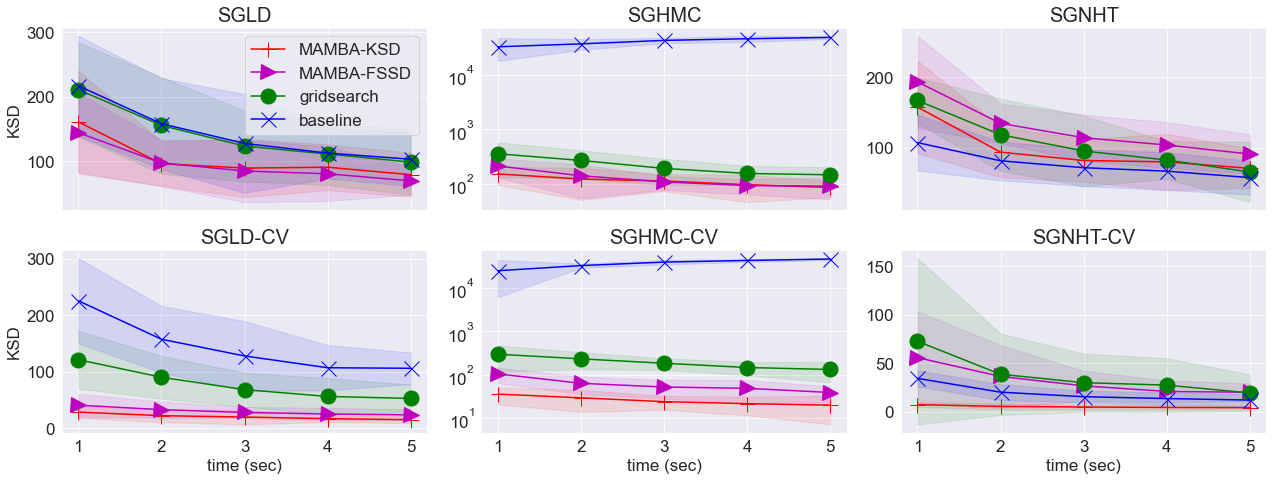

In [46]:

plt.rcParams.update({'font.size':17})

fig, ax = plt.subplots(2,3, figsize=(18,7), sharex=True)

plot_4_ksd_curves(ax[0,0], mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba,
                  mean_ksd_curve_sgld_mamba_fssd, sd_ksd_curve_sgld_mamba_fssd,
                  mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch,
                  mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline,
                  "SGLD"
                 )
plot_4_ksd_curves(ax[1,0], mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba,
                  mean_ksd_curve_sgldCV_mamba_fssd, sd_ksd_curve_sgldCV_mamba_fssd,
                  mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch,
                  mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline,
                  "SGLD-CV"
                 )
plot_4_ksd_curves(ax[0,1], mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba,
                  mean_ksd_curve_sghmc_mamba_fssd, sd_ksd_curve_sghmc_mamba_fssd,
                  mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch,
                  mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline,
                  "SGHMC"
                 )
plot_4_ksd_curves(ax[1,1], mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba,
                  mean_ksd_curve_sghmcCV_mamba_fssd, sd_ksd_curve_sghmcCV_mamba_fssd,
                  mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch,
                  mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline,
                  "SGHMC-CV"
                 )
plot_4_ksd_curves(ax[0,2], mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba,
                  mean_ksd_curve_sgnht_mamba_fssd, sd_ksd_curve_sgnht_mamba_fssd,
                  mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch,
                  mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline,
                  "SGNHT"
                 )
plot_4_ksd_curves(ax[1,2], mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba,
                  mean_ksd_curve_sgnhtCV_mamba_fssd, sd_ksd_curve_sgnhtCV_mamba_fssd,
                  mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch,
                  mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline,
                  "SGNHT-CV"
                 )

ax[0,0].legend()
ax[0,0].set_ylabel("KSD")
ax[1,0].set_ylabel("KSD")
ax[1,0].set_xlabel("time (sec)")
ax[1,1].set_xlabel("time (sec)")
ax[1,2].set_xlabel("time (sec)")

ax[0,1].set_yscale("log")
ax[1,1].set_yscale("log")
plt.tight_layout()

# plt.savefig("images/LR/all_LR_ksd_curves.png")

### new runs

3rd oct 2021

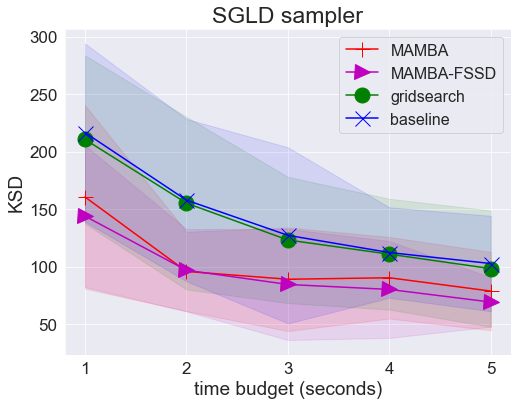

In [31]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba_fssd, marker=">", markersize=15, 
         c='m', label="MAMBA-FSSD")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba_fssd+2*sd_ksd_curve_sgld_mamba_fssd, 
                 mean_ksd_curve_sgld_mamba_fssd-2*sd_ksd_curve_sgld_mamba_fssd, alpha=0.1, color='m')



plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgld_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_baseline+2*sd_ksd_curve_sgld_baseline, 
                 mean_ksd_curve_sgld_baseline-2*sd_ksd_curve_sgld_baseline, alpha=0.1, color='b')

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/LR/sgld_ksd_curves.png")

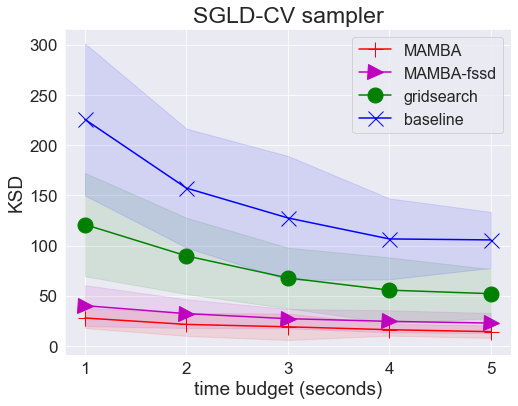

In [32]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba_fssd, marker=">", markersize=15, 
         c='m', label="MAMBA-fssd")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba_fssd+2*sd_ksd_curve_sgldCV_mamba_fssd, 
                 mean_ksd_curve_sgldCV_mamba_fssd-2*sd_ksd_curve_sgldCV_mamba_fssd, alpha=0.1, color='m')



plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_baseline+2*sd_ksd_curve_sgldCV_baseline, 
                 mean_ksd_curve_sgldCV_baseline-2*sd_ksd_curve_sgldCV_baseline, alpha=0.1, color='b')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/LR/sgldcv_ksd_curves.png")

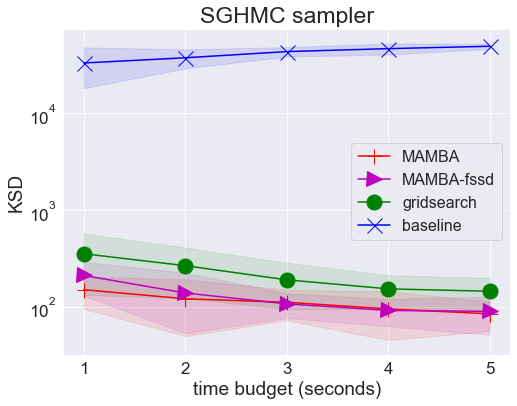

In [33]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')


plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba_fssd, marker=">", markersize=15, 
         c='m', label="MAMBA-fssd")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba_fssd+2*sd_ksd_curve_sghmc_mamba_fssd, 
                 mean_ksd_curve_sghmc_mamba_fssd-2*sd_ksd_curve_sghmc_mamba_fssd, alpha=0.1, color='m')



plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_baseline+2*sd_ksd_curve_sghmc_baseline, 
                 mean_ksd_curve_sghmc_baseline-2*sd_ksd_curve_sghmc_baseline, alpha=0.1, color='b')


plt.title("SGHMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/LR/sghmc_ksd_curves.png")

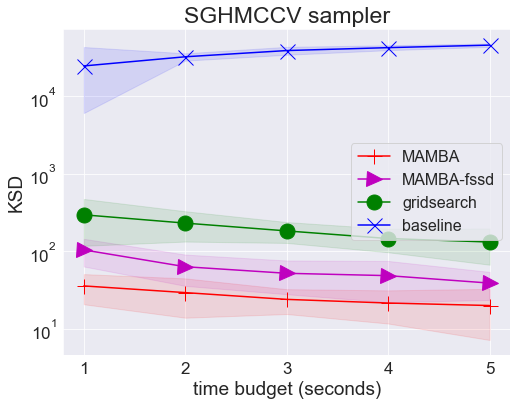

In [34]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')


plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba_fssd, marker=">", markersize=15, 
         c='m', label="MAMBA-fssd")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba_fssd+2*sd_ksd_curve_sghmcCV_mamba_fssd, 
                 mean_ksd_curve_sghmcCV_mamba_fssd-2*sd_ksd_curve_sghmcCV_mamba_fssd, alpha=0.1, color='m')



plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')


plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_baseline+2*sd_ksd_curve_sghmcCV_baseline, 
                 mean_ksd_curve_sghmcCV_baseline-2*sd_ksd_curve_sghmcCV_baseline, alpha=0.1, color='b')

plt.title("SGHMCCV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/LR/sghmccv_ksd_curves.png")


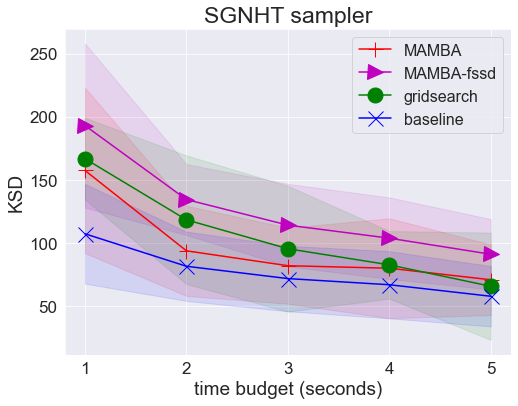

In [35]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba_fssd, marker=">", markersize=15, 
         c='m', label="MAMBA-fssd")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba_fssd+2*sd_ksd_curve_sgnht_mamba_fssd, 
                 mean_ksd_curve_sgnht_mamba_fssd-2*sd_ksd_curve_sgnht_mamba_fssd, alpha=0.1, color='m')



plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_baseline+2*sd_ksd_curve_sgnht_baseline, 
                 mean_ksd_curve_sgnht_baseline-2*sd_ksd_curve_sgnht_baseline, alpha=0.1, color='b')


plt.title("SGNHT sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/LR/sgnht_ksd_curves.png")


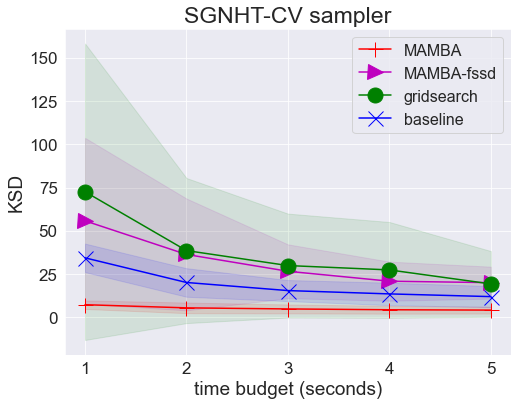

In [36]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')


plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba_fssd, marker=">", markersize=15, 
         c='m', label="MAMBA-fssd")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba_fssd+2*sd_ksd_curve_sgnhtCV_mamba_fssd, 
                 mean_ksd_curve_sgnhtCV_mamba_fssd-2*sd_ksd_curve_sgnhtCV_mamba_fssd, alpha=0.1, color='m')


plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')


plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_baseline+2*sd_ksd_curve_sgnhtCV_baseline, 
                 mean_ksd_curve_sgnhtCV_baseline-2*sd_ksd_curve_sgnhtCV_baseline, alpha=0.1, color='b')


plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/LR/sgnhtcv_ksd_curves.png")
